<a href="https://colab.research.google.com/github/Anurag-Singh-creator/attribution_modeling/blob/main/attribution_manuel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
%%capture
!pip install --upgrade pip
!pip install ChannelAttribution

import numpy as np
import pandas as pd
import datetime
import time
pd.options.mode.chained_assignment = None
import plotly.express as px

from ChannelAttribution import  heuristic_models, markov_model
import plotly.io as pio

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.style as style
import seaborn as sns
%matplotlib inline

import itertools
from collections import Counter, defaultdict
import re
import matplotlib.pyplot as plt
import requests
from PIL import Image
# for url
from urllib.parse import urlparse
from collections import OrderedDict

In [6]:
# this is the focus sequencer data
# df = load_data('/content/drive/MyDrive/Dataz/manuel/bq-results-20230925-090747-1695633750190.csv')
# df.head(5)

# **Data Cleaning**

In [7]:
def correct_journey(journey_str):
    if isinstance(journey_str, str):  # Check if the value is a string
        journey_str = journey_str.replace("faceboook|paid", "facebook|paid")  # Existing replacement
        journey_str = journey_str.replace("l.instagram.com", "instagram.com")  # New replacement
        return journey_str
    return journey_str  # Return the original value if not a string

def clean_journey(journey_str):
    if not isinstance(journey_str, str):  # Check if the value is a string
        return journey_str  # Return the original value if not a string

    # The following regex will match the specific substring followed or preceded by the '>' character.
    # It will then replace the match with nothing or with the '>' character respectively.
    cleaned_journey = re.sub(r'(?:^|>)checkout.stripe.com\|referral(>|$)|(^|>)billing.stripe.com\|referral(>|$)', r'\1', journey_str)

    # If after cleaning, the string is empty, return None (represents null)
    if not cleaned_journey:
        return None

    return cleaned_journey

def check_conversion(row):
    if row['Conversion'] =="Conversion":
        val = 1
    else:
        val = 0
    return val

In [ ]:
def check_null_values(df, column_name):
    """
    Check for null values in a specific column of a DataFrame.

    Parameters:
    - df (pd.DataFrame): The DataFrame to check.
    - column_name (str): The name of the column to check for null values.

    Returns:
    int: The number of null values in the specified column.
    """
    # Check for null values
    null_values = df[df[column_name].isnull()]

    # Get the number of null values
    num_null_values = null_values.shape[0]

    # Print the rows with null values
    if num_null_values > 0:
        print(f"Rows with null values in column '{column_name}':")
        print(null_values)
    else:
        print(f"No null values found in column '{column_name}'.")

    return num_null_values

#**Data Loader**

-This is the function that loads the data for a given time period

-We are taking into account Manuels data

In [22]:
def load_data_in_chunks(filepath, start_date_unix, end_date_unix, chunk_size=50000):
    # List to hold the chunks of data
    chunks = []

    # Read and filter the data in chunks
    for chunk in pd.read_csv(filepath, chunksize=chunk_size):
        # Filter based on the timestamp
        filtered_chunk = chunk[(chunk['event_timestamp'] >= start_date_unix) & (chunk['event_timestamp'] < end_date_unix)]

        # Further filter to exclude rows where 'source_medium' is NaN/empty and 'event_name' is not "purchase"
        filtered_chunk = filtered_chunk[~(filtered_chunk['source_medium'].isna() & (filtered_chunk['event_name'] != "purchase"))]

        chunks.append(filtered_chunk)

    # Concatenate all relevant chunks into a single DataFrame
    df_filtered = pd.concat(chunks, ignore_index=True)

    return df_filtered

def load_filtered_data(filepath, start_date_str=None, end_date_str=None, specific_month_year=None):
    # If specific_month_year is provided, override start and end dates
    if specific_month_year:
        start_date_str = specific_month_year
        end_date_str = specific_month_year

    # Convert year/month to UNIX timestamp
    if start_date_str and end_date_str:
        start_date_unix = time.mktime(datetime.datetime.strptime(start_date_str, "%Y/%m").timetuple()) * 10**6
        end_date_unix = time.mktime((datetime.datetime.strptime(end_date_str, "%Y/%m") + datetime.timedelta(days=30)).timetuple()) * 10**6

        df_filtered = load_data_in_chunks(filepath, start_date_unix, end_date_unix)
    else:
        df_filtered = pd.read_csv(filepath)

    return df_filtered

# Usage
# Load data for a specific month/year
date = "2023/09"
filepath = '/content/drive/MyDrive/Dataz/manuel/cleaned_data.csv'
df = load_filtered_data(filepath, specific_month_year=date)

Following are the data ranges and the corresponding count of the data points in the originnal data:

```
2023-02    1077752
2023-03    1558979
2023-04    1138526
2023-05    1061704
2023-06     742657
2023-07     616669
2023-08     690847
2023-09     709807
Name: year_month, dtype: int64
```
We load a subset of this data by specifying a data range in the data loader function


Checking the time period/range of the dataset

In [17]:
df

,user_pseudo_id,event_timestamp,event_name,source_medium,ga_session_id
0,c75e379cbf9b47006e6d1a00fa9062ef,1693527479746000,firebase_campaign,google|organic,1.693527e+09
1,ARSWv4L0BEm9GuqTQ09C9yp3YEJp+OLdFYzQ25Y7/tY=.1...,1693528012073337,page_view,google|paid,1.693528e+09
2,ARSWv4L0BEm9GuqTQ09C9yp3YEJp+OLdFYzQ25Y7/tY=.1...,1693528012165668,session_start,google|paid,1.693528e+09
3,ARSWv4L0BEm9GuqTQ09C9yp3YEJp+OLdFYzQ25Y7/tY=.1...,1693528012165668,first_visit,google|paid,1.693528e+09
4,ARSWv4L0BEm9GuqTQ09C9yp3YEJp+OLdFYzQ25Y7/tY=.1...,1693528012165668,page_view,google|paid,1.693528e+09
...,...,...,...,...,...
149602,lF90AJFC3A7SCJxQBQ7AIKz7aqzCB1ppRZmEcq+spCo=.1...,1695592697965574,logged,google|organic,1.695593e+09
149603,lF90AJFC3A7SCJxQBQ7AIKz7aqzCB1ppRZmEcq+spCo=.1...,1695592697980293,page_view,google|organic,1.695593e+09
149604,168071229.1695536111,1695592703155086,Clarity,google|organic,1.695593e+09
149605,168071229.1695536111,1695592707164756,home,google|organic,1.695593e+09


In [11]:
def check_null_values(df, column_name):
    """
    Check for null values in a specific column of a DataFrame.

    Parameters:
    - df (pd.DataFrame): The DataFrame to check.
    - column_name (str): The name of the column to check for null values.

    Returns:
    int: The number of null values in the specified column.
    """
    # Check for null values
    null_values = df[df[column_name].isnull()]

    # Get the number of null values
    num_null_values = null_values.shape[0]

    # Print the rows with null values
    if num_null_values > 0:
        print(f"Rows with null values in column '{column_name}':")
        print(null_values)
    else:
        print(f"No null values found in column '{column_name}'.")

    return num_null_values


check_null_values(df,"source_medium")

Rows with null values in column 'source_medium':
                                           user_pseudo_id   event_timestamp  \
18      aTBz6KfVSsI3W2TIWodXaicQOCSgYtOrz4dEqqBACAw=.1...  1693528666914899   
691                                 2023054415.1693212748  1693552300367122   
783     NeoMx7+IbNCD2D4c64S7LPmxeu6hsJMKV3LrhM6eNZI=.1...  1693553735700010   
1156                                 790788452.1693559095  1693559220320313   
1274                                2008348978.1693559505  1693559871827422   
...                                                   ...               ...   
146985                               240334601.1686638023  1695569016092627   
146996                              1247190765.1670903138  1695569060448211   
147192                               547775575.1695569683  1695570519601334   
148007                              1083954487.1695575784  1695576509156784   
149566                              2068317834.1693858310  1695592565625386   

  

365

In [10]:
def count_date_types(df):
    # Convert timestamp and extract year and month
    df['date'] = pd.to_datetime(df['event_timestamp'], unit='us')
    df['year'] = df['date'].dt.year
    df['month'] = df['date'].dt.month

    # Combine year and month into a single column and count occurrences
    df['year_month'] = df['year'].astype(str) + '-' + df['month'].astype(str).str.zfill(2)
    date_counts = df['year_month'].value_counts().sort_index()

    return date_counts

# Usage
date_counts = count_date_types(df)
date_counts

2023-09    149607
Name: year_month, dtype: int64

# Journey Construction

In [19]:
def compute_user_journey(df):
    df['source_medium'] = df['source_medium'].fillna('unknown')
    df.sort_values(by=['user_pseudo_id', 'event_timestamp'], inplace=True)
    results = []
    journey = []
    conversion = "No Conversion"
    start_timestamp = None
    last_source_medium = None
    last_session_id = None

    for _, row in df.iterrows():
        # Initialize or update the journey
        if not journey:
            journey = [row['source_medium']]
            start_timestamp = row['event_timestamp']
        else:
            # Append the source_medium to the journey if it's different from the last one
            # or if the ga_session_id has changed
            if str(row['source_medium']) != last_source_medium or row['ga_session_id'] != last_session_id: journey.append(str(row['source_medium']))

        # Check if a conversion has occurred
        if row['event_name'] == 'purchase':
            conversion = "Conversion"

        # If there’s a new user or session, save the current journey and start a new one
        if len(journey) > 1 and (conversion == "Conversion" or \
            (results and row['user_pseudo_id'] != results[-1]['user_pseudo_id'])):
            results.append({
                'user_pseudo_id': row['user_pseudo_id'],
                'Journey': " > ".join(journey),
                'Conversion': conversion,
                'start_timestamp': start_timestamp
            })
            journey = [row['source_medium']] if conversion == "Conversion" else []
            conversion = "No Conversion"
            start_timestamp = row['event_timestamp']

        # Update the last source_medium and last_session_id for the next iteration
        last_source_medium = row['source_medium']
        last_session_id = row['ga_session_id']

    # Add the last journey to results if it's not empty
    if journey and (not results or row['user_pseudo_id'] == results[-1]['user_pseudo_id']):
        results.append({
            'user_pseudo_id': row['user_pseudo_id'],
            'Journey': " > ".join(journey),
            'Conversion': conversion,
            'start_timestamp': start_timestamp
        })

    return pd.DataFrame(results)

# Calling the function and displaying the result
result_df = compute_user_journey(df)
#print(result_df.to_markdown())


In [23]:
import pandas as pd

def compute_user_journey(df):
    df.sort_values(by=['user_pseudo_id', 'event_timestamp'], inplace=True)
    results = []
    journey = []
    conversion = "No Conversion"
    start_timestamp = None
    last_source_medium = None
    last_session_id = None

    for _, row in df.iterrows():
        # Initialize or update the journey
        current_source_medium = str(row['source_medium']) if pd.notna(row['source_medium']) else 'unknown'

        if not journey:
            journey = [current_source_medium]
            start_timestamp = row['event_timestamp']
        else:
            # Append the source_medium to the journey if it's different from the last one
            # or if the ga_session_id has changed
            if current_source_medium != last_source_medium or row['ga_session_id'] != last_session_id:
                journey.append(current_source_medium)

        # Check if a conversion has occurred
        if row['event_name'] == 'purchase':
            conversion = "Conversion"

        # If there’s a new user or session, save the current journey and start a new one
        if len(journey) > 1 and (conversion == "Conversion" or \
            (results and row['user_pseudo_id'] != results[-1]['user_pseudo_id'])):

            # Construct the journey string and handle 'unknown' as per your logic
            journey_str = " > ".join([sm for sm in journey if sm != 'unknown'])
            if not journey_str:
                journey_str = 'unknown'

            results.append({
                'user_pseudo_id': row['user_pseudo_id'],
                'Journey': journey_str,
                'Conversion': conversion,
                'start_timestamp': start_timestamp
            })
            journey = [current_source_medium] if conversion == "Conversion" else []
            conversion = "No Conversion"
            start_timestamp = row['event_timestamp']

        # Update the last source_medium and last_session_id for the next iteration
        last_source_medium = current_source_medium
        last_session_id = row['ga_session_id']

    # Add the last journey to results if it's not empty
    if journey and (not results or row['user_pseudo_id'] == results[-1]['user_pseudo_id']):
        journey_str = " > ".join([sm for sm in journey if sm != 'unknown'])
        if not journey_str:
            journey_str = 'unknown'
        results.append({
            'user_pseudo_id': row['user_pseudo_id'],
            'Journey': journey_str,
            'Conversion': conversion,
            'start_timestamp': start_timestamp
        })

    return pd.DataFrame(results)
result_df = compute_user_journey(df)

If you want to save the result_df then run the following command

In [ ]:
#result_df.to_csv('test_1_result.csv', index=False)

# **Attribution Model**
###-Markov Chain

###-Last Touch

<ipython-input-27-309f335f69e2>:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  attribution_df = df.groupby(['Journey'], as_index=False).sum()


*** Looking to run more advanced attribution? Try ChannelAttribution Pro for free! Visit https://channelattribution.io/product
Number of simulations: 100000 - Convergence reached: 1.95% < 5.00%
Percentage of simulated paths that successfully end before maximum number of steps (546) is reached: 99.99%
*** Looking to run more advanced attribution? Try ChannelAttribution Pro for free! Visit https://channelattribution.io/product


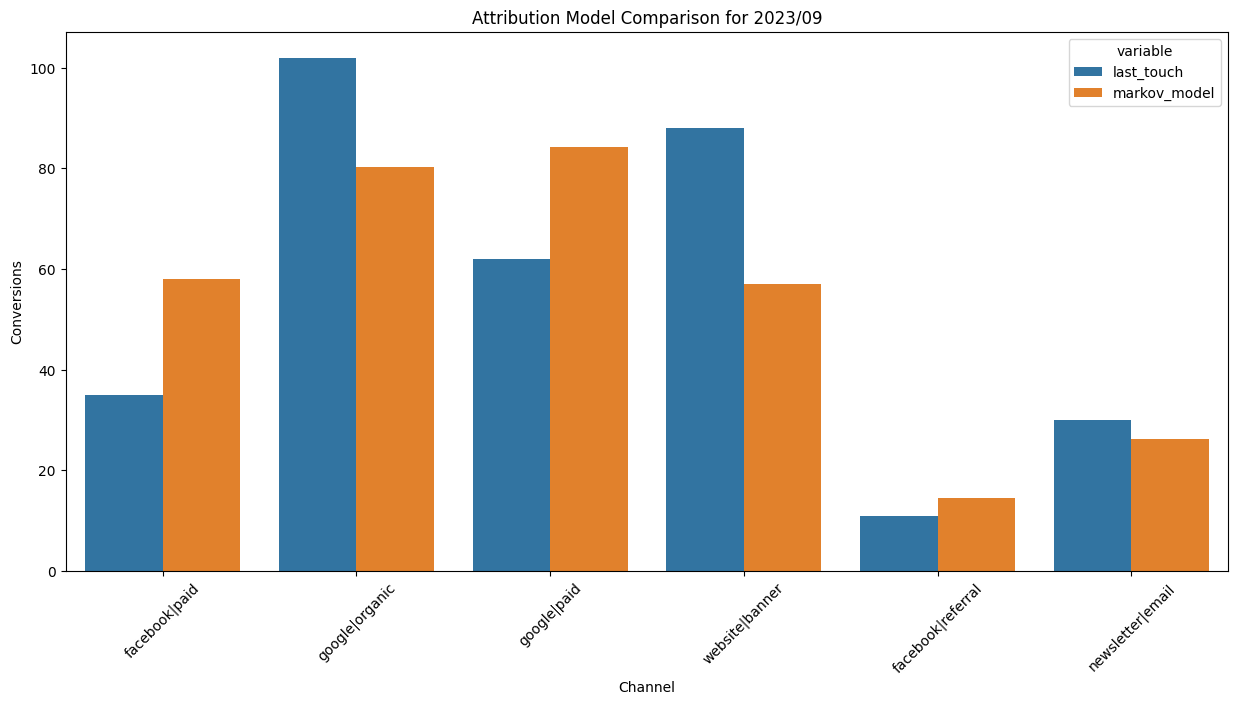

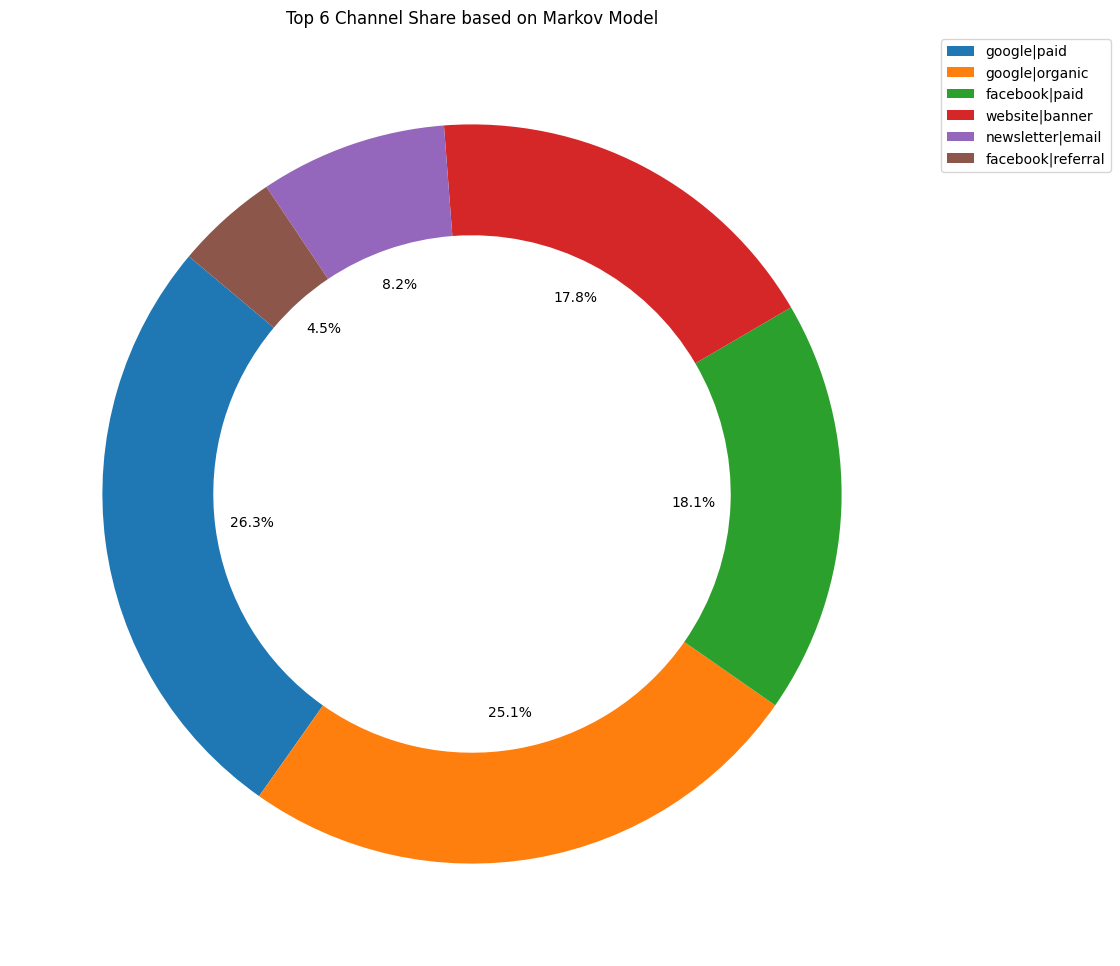

In [27]:
def preprocess_data(df):
    # Conversion calculation (assuming check_conversion is defined elsewhere)
    df['Conversion'] = df.apply(check_conversion, axis=1)

    # Convert Journey elements to lowercase, ensuring they are strings first
    df['Journey'] = df['Journey'].apply(lambda x: str(x).lower() if pd.notnull(x) else x)

    # Correct the Journey column values
    df['Journey'] = df['Journey'].apply(correct_journey)

    # Clean the Journey column values using the new function
    df['Journey'] = df['Journey'].apply(clean_journey)

    # Other preprocessing
 #   df.drop(columns=['user_pseudo_id', 'start_timestamp'], axis=1, inplace=True)
    df['null'] = np.where(df['Conversion'] == 0, 1, 0)

    return df

def calculate_attribution(df):
    assert 'Conversion' in df.columns, "'Conversion' column not found in df"
    assert df['Conversion'].sum() > 0, "'Conversion' column sums to zero or NaN"

    # Filter out rows where Journey contains "checkout.stripe.com"
    df = df[~df['Journey'].str.contains('checkout.stripe.com', na=False)]

    attribution_df = df.groupby(['Journey'], as_index=False).sum()
    attribution_df.rename(columns={
        "Conversion": "total_conversions",
        "null": "total_null",
        "conversion_value_euro": "total_conversion_value"
    }, inplace=True)
    H = heuristic_models(attribution_df, "Journey", "total_conversions")

    # Extracting Last Touch Attribution
    last_touch = H[['channel_name', 'last_touch']]
    last_touch.columns = ['channel_name', 'last_touch']

    M = markov_model(attribution_df, "Journey", "total_conversions")
    M = M[['channel_name', 'total_conversions']]
    M.columns = ['channel_name', 'markov_model']

    # Merging the two dataframes based on the channel name
    R = pd.merge(last_touch, M, on="channel_name", how="inner")

    return pd.melt(R, id_vars="channel_name")


def plot_data(data, top_n, date_str):
    # Select top_n values
    top_channels = data.sort_values('value', ascending=False)['channel_name'].unique()[:top_n]
    data = data[data['channel_name'].isin(top_channels)]

    plt.figure(figsize=(15, 7))
    sns.barplot(data=data, x='channel_name', y='value', hue='variable')
    plt.title(f'Attribution Model Comparison for {date_str}')
    plt.ylabel('Conversions')
    plt.xlabel('Channel')
    plt.xticks(rotation=45)  # Tilt the x-axis labels
    plt.show()


def plot_pie_chart(data, top_n):
    # Assuming 'markov_model' results for the pie chart
    markov_data = data[data['variable'] == 'markov_model']

    # Sort data to get the top channels based on 'value'
    markov_data = markov_data.sort_values(by='value', ascending=False).head(top_n)

    # Increase chart size if needed
    plt.figure(figsize=(12, 12))

    # Plot the pie chart with labels outside the pie and add a legend
    plt.pie(markov_data['value'], autopct='%1.1f%%', startangle=140,
            wedgeprops=dict(width=0.3), labeldistance=1.05)

    plt.legend(markov_data['channel_name'], loc='upper left', bbox_to_anchor=(1, 1))
    plt.title('Top {} Channel Share based on Markov Model'.format(top_n))
    plt.show()


def main_analysis(result_df, top_n, start_date_str=None, end_date_str=None):
    df = preprocess_data(result_df)
    data_to_plot = calculate_attribution(df)

    # Construct date_str elegantly
    if start_date_str and end_date_str and start_date_str != end_date_str:
        date_str = f"{start_date_str} to {end_date_str}"
    elif start_date_str:
        date_str = start_date_str
    elif end_date_str:
        date_str = end_date_str
    else:
        date_str = "All Available Data"

    plot_data(data_to_plot, top_n, date_str)
    plot_pie_chart(data_to_plot, top_n)

# Usage example
start_date_str = date
end_date_str = start_date_str
df = main_analysis(result_df, top_n=6, start_date_str=start_date_str, end_date_str=end_date_str)
